CREATING KMA WARD BOUNDARIES FROM OSM DATA
Loading OSM data...
Found 1 polygons, 281 points, 3 lines
Using Kolkata boundary from OSM
Found 281 neighborhoods within KMA
Creating Voronoi-based ward boundaries...

✅ Created 281 ward boundaries

Saving files...
  ✓ Saved: kma_wards_osm_based.geojson
  ✓ Saved: kma_wards_for_earth_engine.geojson
  ✓ Saved: kma_neighborhoods.geojson
  ✓ Saved: kma_wards_map.png

WARD STATISTICS

Wards by Region:
              ward_count  avg_area_sqkm
region                                 
KMA_Suburb           161      20.613382
Kolkata_Core         120       1.720876

Total Wards: 281
Average Ward Size: 12.55 sq km
Min Ward Size: 0.07 sq km
Max Ward Size: 612.39 sq km

Wards with known neighborhood names: 281

KEY FLOOD-PRONE AREAS IDENTIFIED
  ✓ Behala: Found at 1 location(s)
  ✓ Tollygunge: Found at 1 location(s)
  ✓ Jadavpur: Found at 1 location(s)
  ✓ Lake Town: Found at 1 location(s)
  ✓ Ultadanga: Found at 1 location(s)
  ✓ Kidderpore: Found at 1 loc

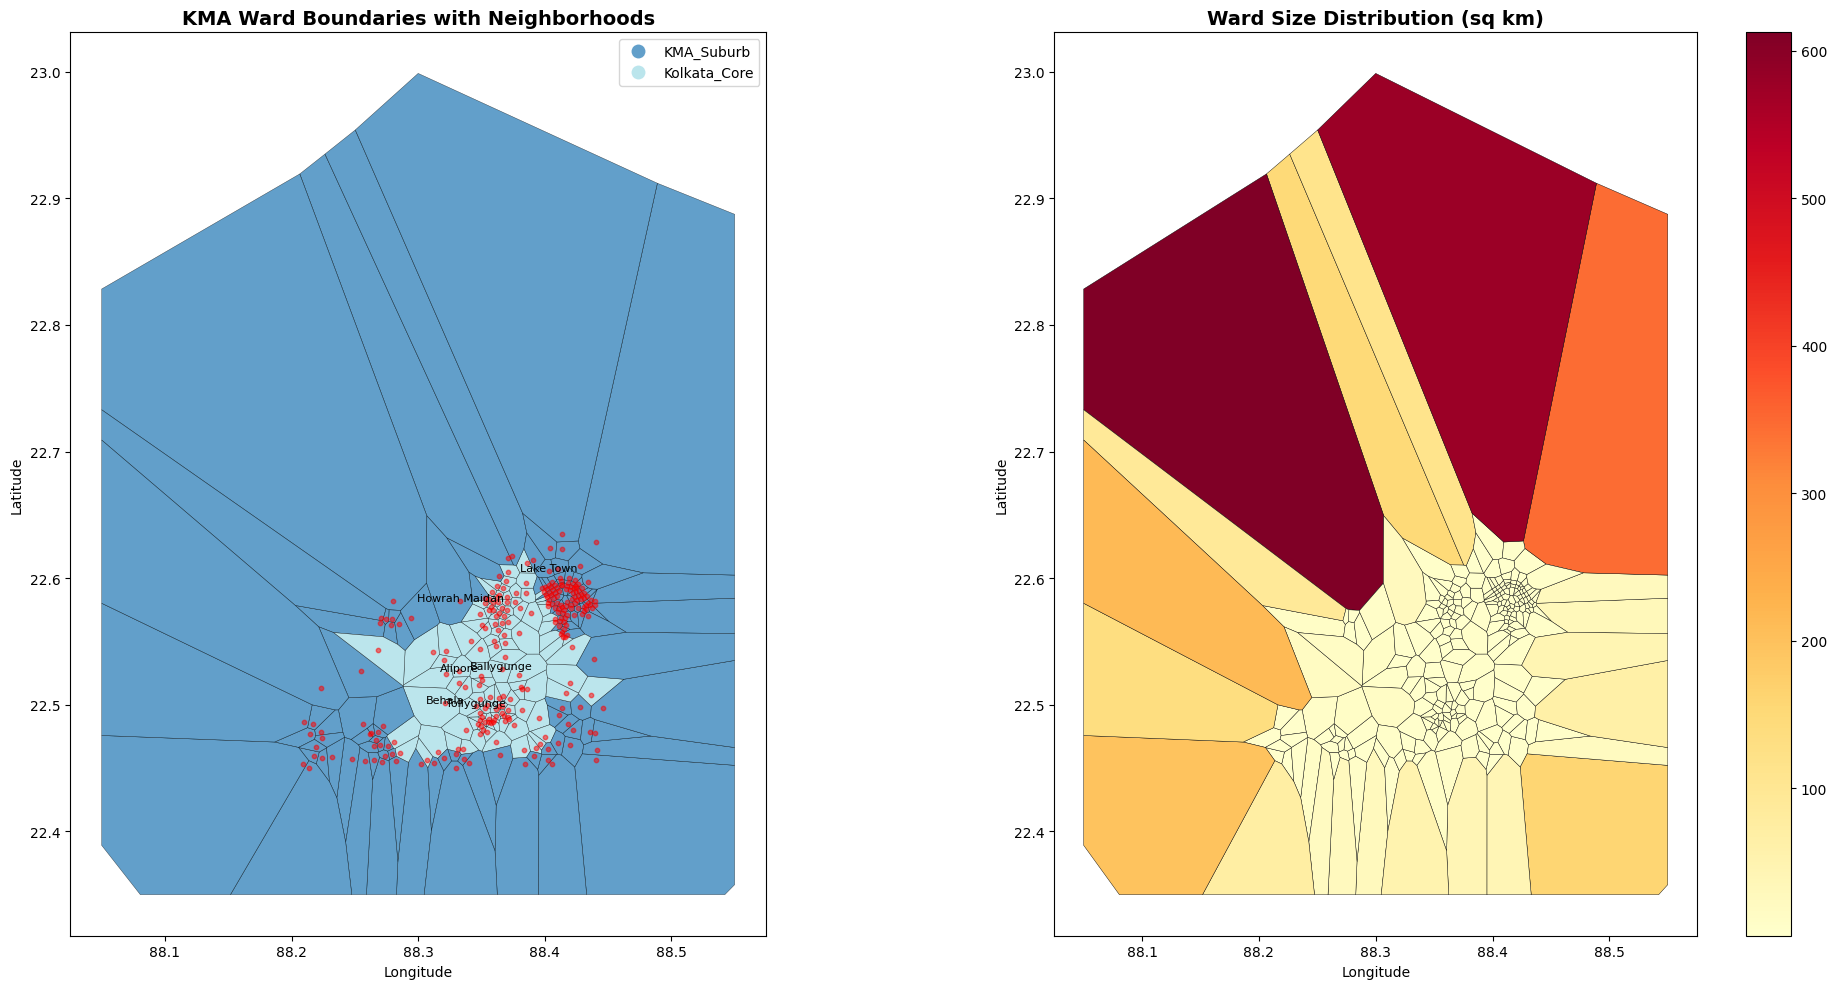

In [1]:
"""
Process OSM GeoJSON data and create functional ward boundaries for KMA flood detection
Combines real neighborhood data with grid-based ward approximation
"""

import json
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon, box
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def load_and_process_osm_data(geojson_path):
    """
    Load the OSM GeoJSON and extract useful components
    """
    # Load the GeoJSON file
    with open(geojson_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Separate different types of features
    polygons = []
    points = []
    lines = []
    
    for feature in data['features']:
        if feature['geometry']['type'] == 'Polygon':
            polygons.append(feature)
        elif feature['geometry']['type'] == 'Point':
            points.append(feature)
        elif feature['geometry']['type'] == 'LineString':
            lines.append(feature)
    
    print(f"Found {len(polygons)} polygons, {len(points)} points, {len(lines)} lines")
    
    # Create GeoDataFrames
    polygon_gdf = gpd.GeoDataFrame.from_features(polygons) if polygons else None
    point_gdf = gpd.GeoDataFrame.from_features(points) if points else None
    line_gdf = gpd.GeoDataFrame.from_features(lines) if lines else None
    
    return polygon_gdf, point_gdf, line_gdf

def create_voronoi_wards_from_neighborhoods(point_gdf, boundary_polygon):
    """
    Create ward-like boundaries using Voronoi tessellation of neighborhood points
    This creates natural boundaries based on actual neighborhood locations
    """
    from scipy.spatial import Voronoi
    from shapely.geometry import Polygon
    
    # Extract coordinates
    coords = np.array([[p.x, p.y] for p in point_gdf.geometry])
    
    # Add boundary points to ensure complete coverage
    minx, miny, maxx, maxy = boundary_polygon.bounds
    boundary_points = [
        [minx-0.1, miny-0.1], [minx-0.1, maxy+0.1],
        [maxx+0.1, miny-0.1], [maxx+0.1, maxy+0.1]
    ]
    
    all_points = np.vstack([coords, boundary_points])
    
    # Create Voronoi diagram
    vor = Voronoi(all_points)
    
    # Create polygons from Voronoi regions
    voronoi_polygons = []
    for idx, point_idx in enumerate(range(len(coords))):
        region = vor.regions[vor.point_region[point_idx]]
        if region and -1 not in region:
            polygon = Polygon([vor.vertices[i] for i in region])
            # Clip to boundary
            clipped = polygon.intersection(boundary_polygon)
            if clipped.area > 0:
                voronoi_polygons.append({
                    'geometry': clipped,
                    'neighborhood': point_gdf.iloc[idx]['name'] if 'name' in point_gdf.columns else f'Area_{idx}',
                    'centroid_lon': point_gdf.iloc[idx].geometry.x,
                    'centroid_lat': point_gdf.iloc[idx].geometry.y
                })
    
    return gpd.GeoDataFrame(voronoi_polygons, crs='EPSG:4326')

def create_hybrid_ward_system(geojson_path, output_prefix='kma'):
    """
    Create a hybrid ward system combining:
    1. Actual neighborhood points from OSM
    2. Grid-based subdivision for areas without neighborhood data
    3. Voronoi tessellation for natural boundaries
    """
    
    # Load OSM data
    print("Loading OSM data...")
    polygon_gdf, point_gdf, line_gdf = load_and_process_osm_data(geojson_path)
    
    # Get Kolkata boundary (largest polygon)
    if polygon_gdf is not None and len(polygon_gdf) > 0:
        kolkata_boundary = polygon_gdf.iloc[0].geometry  # Main Kolkata polygon
        print(f"Using Kolkata boundary from OSM")
    else:
        # Fallback to approximate boundary
        kolkata_boundary = box(88.20, 22.45, 88.45, 22.65)
        print("Using approximate Kolkata boundary")
    
    # Define extended KMA boundary (includes suburbs)
    kma_boundary = box(88.05, 22.35, 88.55, 23.05)
    
    # Filter points within KMA
    if point_gdf is not None:
        point_gdf = point_gdf[point_gdf.geometry.within(kma_boundary)]
        print(f"Found {len(point_gdf)} neighborhoods within KMA")
    
    # Strategy 1: Create Voronoi-based wards from neighborhood points
    if point_gdf is not None and len(point_gdf) > 20:
        print("Creating Voronoi-based ward boundaries...")
        voronoi_wards = create_voronoi_wards_from_neighborhoods(point_gdf, kma_boundary)
        
        # Add ward IDs
        voronoi_wards['ward_id'] = [f'W_{i:03d}' for i in range(1, len(voronoi_wards) + 1)]
        voronoi_wards['ward_no'] = range(1, len(voronoi_wards) + 1)
        voronoi_wards['area_sqkm'] = voronoi_wards.geometry.area * 111 * 111
        
        # Identify which wards are in core Kolkata vs suburbs
        voronoi_wards['region'] = voronoi_wards.geometry.apply(
            lambda g: 'Kolkata_Core' if g.centroid.within(kolkata_boundary) else 'KMA_Suburb'
        )
        
        wards_gdf = voronoi_wards
    else:
        # Strategy 2: Fallback to grid-based approach
        print("Creating grid-based ward boundaries...")
        wards_gdf = create_grid_wards(kma_boundary, target_wards=300)
    
    # Add neighborhood names where available
    if point_gdf is not None and 'name' in point_gdf.columns:
        # Create a mapping of areas to known neighborhoods
        neighborhood_map = {}
        for idx, row in point_gdf.iterrows():
            point = row.geometry
            for ward_idx, ward in wards_gdf.iterrows():
                if point.within(ward.geometry):
                    neighborhood_map[ward_idx] = row['name']
                    break
        
        # Add neighborhood names to wards
        wards_gdf['neighborhood_name'] = wards_gdf.index.map(
            lambda x: neighborhood_map.get(x, '')
        )
    
    return wards_gdf, point_gdf

def create_grid_wards(boundary, target_wards=300):
    """
    Create a grid of wards within the boundary
    """
    minx, miny, maxx, maxy = boundary.bounds
    
    # Calculate grid dimensions
    aspect_ratio = (maxx - minx) / (maxy - miny)
    n_cols = int(np.sqrt(target_wards * aspect_ratio))
    n_rows = int(target_wards / n_cols)
    
    width = (maxx - minx) / n_cols
    height = (maxy - miny) / n_rows
    
    wards = []
    ward_no = 1
    
    for i in range(n_cols):
        for j in range(n_rows):
            if ward_no > target_wards:
                break
            
            ward_geom = box(
                minx + i * width,
                miny + j * height,
                minx + (i + 1) * width,
                miny + (j + 1) * height
            )
            
            # Check if ward intersects with boundary
            if ward_geom.intersects(boundary):
                wards.append({
                    'geometry': ward_geom,
                    'ward_id': f'W_{ward_no:03d}',
                    'ward_no': ward_no,
                    'grid_col': i,
                    'grid_row': j,
                    'area_sqkm': ward_geom.area * 111 * 111,
                    'centroid_lon': ward_geom.centroid.x,
                    'centroid_lat': ward_geom.centroid.y
                })
                ward_no += 1
    
    return gpd.GeoDataFrame(wards, crs='EPSG:4326')

def visualize_ward_system(wards_gdf, neighborhoods_gdf=None, save_path='kma_wards_map.png'):
    """
    Visualize the created ward system with neighborhoods
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot 1: Wards colored by region
    ax = axes[0]
    if 'region' in wards_gdf.columns:
        wards_gdf.plot(column='region', ax=ax, legend=True, 
                      cmap='tab20', edgecolor='black', linewidth=0.3, alpha=0.7)
    else:
        wards_gdf.plot(ax=ax, edgecolor='black', facecolor='lightblue', 
                      linewidth=0.3, alpha=0.7)
    
    # Add neighborhood points if available
    if neighborhoods_gdf is not None:
        neighborhoods_gdf.plot(ax=ax, color='red', markersize=10, alpha=0.5)
        
        # Label major neighborhoods
        major_neighborhoods = ['Behala', 'Salt Lake', 'Lake Town', 'Howrah', 
                             'Alipore', 'Ballygunge', 'Tollygunge']
        for idx, row in neighborhoods_gdf.iterrows():
            if 'name' in neighborhoods_gdf.columns:
                if any(major in str(row['name']) for major in major_neighborhoods):
                    ax.annotate(row['name'], xy=(row.geometry.x, row.geometry.y),
                              fontsize=8, ha='center')
    
    ax.set_title('KMA Ward Boundaries with Neighborhoods', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Plot 2: Ward density heatmap
    ax = axes[1]
    wards_gdf.plot(column='area_sqkm', ax=ax, legend=True, 
                  cmap='YlOrRd', edgecolor='black', linewidth=0.3)
    ax.set_title('Ward Size Distribution (sq km)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    return fig

# ============================================
# MAIN EXECUTION
# ============================================

if __name__ == "__main__":
    # Input file path (update this to your downloaded GeoJSON)
    input_geojson = '../data/raw/kma_wards_overpass.geojson'
    
    print("="*60)
    print("CREATING KMA WARD BOUNDARIES FROM OSM DATA")
    print("="*60)
    
    # Create hybrid ward system
    wards_gdf, neighborhoods_gdf = create_hybrid_ward_system(input_geojson)
    
    print(f"\n✅ Created {len(wards_gdf)} ward boundaries")
    
    # Save outputs
    print("\nSaving files...")
    
    # Save ward boundaries
    wards_gdf.to_file('../data/wards/kma_wards_osm_based.geojson', driver='GeoJSON')
    print("  ✓ Saved: kma_wards_osm_based.geojson")
    
    # Save simplified version for Earth Engine (fewer fields)
    wards_simple = wards_gdf[['ward_id', 'ward_no', 'geometry']].copy()
    wards_simple.to_file('../data/wards/kma_wards_for_earth_engine.geojson', driver='GeoJSON')
    print("  ✓ Saved: kma_wards_for_earth_engine.geojson")
    
    # Save neighborhood reference
    if neighborhoods_gdf is not None:
        neighborhoods_gdf.to_file('../data/wards/kma_neighborhoods.geojson', driver='GeoJSON')
        print("  ✓ Saved: kma_neighborhoods.geojson")
    
    # Create visualization
    fig = visualize_ward_system(wards_gdf, neighborhoods_gdf)
    print("  ✓ Saved: kma_wards_map.png")
    
    # Print statistics
    print("\n" + "="*60)
    print("WARD STATISTICS")
    print("="*60)
    
    if 'region' in wards_gdf.columns:
        region_stats = wards_gdf.groupby('region').agg({
            'ward_id': 'count',
            'area_sqkm': 'mean'
        }).rename(columns={'ward_id': 'ward_count', 'area_sqkm': 'avg_area_sqkm'})
        print("\nWards by Region:")
        print(region_stats)
    
    print(f"\nTotal Wards: {len(wards_gdf)}")
    print(f"Average Ward Size: {wards_gdf['area_sqkm'].mean():.2f} sq km")
    print(f"Min Ward Size: {wards_gdf['area_sqkm'].min():.2f} sq km")
    print(f"Max Ward Size: {wards_gdf['area_sqkm'].max():.2f} sq km")
    
    if 'neighborhood_name' in wards_gdf.columns:
        named_wards = wards_gdf[wards_gdf['neighborhood_name'] != '']
        print(f"\nWards with known neighborhood names: {len(named_wards)}")
    
    # Important neighborhoods for flood tracking
    print("\n" + "="*60)
    print("KEY FLOOD-PRONE AREAS IDENTIFIED")
    print("="*60)
    
    flood_prone = ['Behala', 'Tollygunge', 'Jadavpur', 'Lake Town', 
                   'Salt Lake', 'Ultadanga', 'Kidderpore', 'Garden Reach']
    
    if neighborhoods_gdf is not None and 'name' in neighborhoods_gdf.columns:
        for area in flood_prone:
            matches = neighborhoods_gdf[
                neighborhoods_gdf['name'].str.contains(area, case=False, na=False)
            ]
            if len(matches) > 0:
                print(f"  ✓ {area}: Found at {len(matches)} location(s)")
    
    print("\n✅ READY FOR EARTH ENGINE UPLOAD!")
    print("\nNext steps:")
    print("1. Upload 'kma_wards_for_earth_engine.geojson' to Earth Engine")
    print("2. Use neighborhood names for validating against news reports")
    print("3. Process MODIS/Sentinel data for these ward boundaries")